### **Initial case study DATAMOLE**

#### Tomáš Novotný

# **ASSIGNMENT**

## Data and Label Description

### Data
The data consists of the following columns (in this particular order):

- MachineId: Id of the machine
- MeasurementId: Id of the measured cycle
- Pressure: Air pressure (kPa)

The data does not contain timestamps, but for each machine and measured cycle combination, observations (i.e. rows) of the pressure values are ordered by time, and the time intervals between individual observations are always the same.

### Labels
The labels consist of the following columns (in this particular order):

- MachineId: Id of the machine
- MeasurementId: Id of the measured cycle
- PumpFailed: True if pump failed
- SlowStart: True if the pressure rose slowly
- SlowEnd: True if the pressure dropped slowly

## Task Description

### Task
Develop a `predictive model` for the `PumpFailed` column and report its `performance` in appropriate metrics.

### Model Explanation
Please `explain` your model in detail.

# **SOLUTION**

#### Library import

In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import random

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, random_split

from sklearn.metrics import ConfusionMatrixDisplay


2024-04-04 10:52:26.509587: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 10:52:27.437683: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Loading data

In [2]:
data = pd.read_parquet("data/data.parquet")
data.describe()

labels = pd.read_csv("data/labels.csv")

## Data survey

The columns are in suitable data types for the merge of the tables

In [3]:
display(data.dtypes)
display(labels.dtypes)

MachineId         object
MeasurementId      int64
Pressure         float64
dtype: object

MachineId        object
MeasurementId     int64
PumpFailed       object
SlowStart        object
SlowEnd          object
dtype: object

NULL value count in columns

In [4]:
display(data.isnull().sum())
display(labels.isnull().sum())

MachineId        0
MeasurementId    0
Pressure         0
dtype: int64

MachineId           0
MeasurementId       0
PumpFailed        485
SlowStart        8085
SlowEnd          8085
dtype: int64

The target variable is `PumpFailed`, therefore variables SlowStart/SlowEnd can be deleted from the dataframe

In [5]:
labels.drop(["SlowStart", "SlowEnd"], axis=1, inplace=True)

Table, which shows measurement count for unique pair MachineId - MeasurementId

In [6]:
data.groupby(['MachineId', 'MeasurementId']).size().reset_index(name='Count')

,MachineId,MeasurementId,Count
0,0_0_0,-1,101711
1,0_0_0,0,368
2,0_0_0,215,732
3,0_0_0,237,589
4,0_0_0,353,349
...,...,...,...
27380,9_5_3,4253,337
27381,9_5_3,4254,478
27382,9_5_3,4255,436
27383,9_5_3,4256,549


Measurement count differs throughout dataframe

Measurement ID -1 contains only NULL values in the target variable (trap? :) )

In [7]:
print(len(labels["MeasurementId"].unique()), "!=", len(labels.dropna()["MeasurementId"].unique()))
print(set(labels["MeasurementId"].unique()) - set(labels.dropna()["MeasurementId"].unique()))

8836 != 8835
{-1}


In [8]:
print("Number of distinct machines:", len(data["MachineId"].unique()))

Number of distinct machines: 556


## Příprava datasetu

Merges dataframes using unique pair MachineId and MeasurementId

Each cycle has array of measured values in the column Pressure

The only column that has NULL values is the target variable, therefore NULL rows are dropped

In [9]:
df = data.pivot_table(index=['MachineId', 'MeasurementId'], columns=None, values='Pressure', aggfunc=list)

df.reset_index(inplace=True)

df = pd.merge(df, labels, on=['MachineId', 'MeasurementId'], how='left')

df.dropna(inplace=True)

df = df[['MachineId', 'MeasurementId', 'PumpFailed', 'Pressure']]

df["Pressure"] = df["Pressure"].apply(lambda x: np.array(x))

display(df)

,MachineId,MeasurementId,PumpFailed,Pressure
1,0_0_0,0,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0_0_0,215,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0_0_0,237,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0_0_0,353,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,0_0_0,411,True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
27380,9_5_3,4253,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
27381,9_5_3,4254,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
27382,9_5_3,4255,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
27383,9_5_3,4256,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


There are no NULL values

In [10]:
df.isnull().sum()

MachineId        0
MeasurementId    0
PumpFailed       0
Pressure         0
dtype: int64

Proportion of False and True labels

It would be better if they are even, but it is manageable I guess

[Text(0, 0, 'Not Failed'), Text(1, 0, 'Failed')]

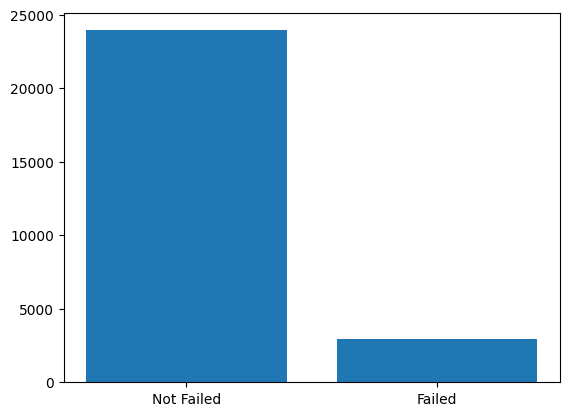

In [11]:
fig, ax = plt.subplots()
ax.bar([0,1], [len(df[df["PumpFailed"] == False]), len(df[df["PumpFailed"] == True])])
ax.set_xticks([0, 1])
ax.set_xticklabels(["Not Failed", "Failed"])

## Výběr modelu

Let's analyze the cycles

In [12]:
mlen = df["Pressure"].apply(lambda x: len(x))
nonzero = df["Pressure"].apply(lambda x: np.array([i for i in x if i != 0]))
nonlen = [len(x) for x in nonzero]

Number of measured values in the cycle distribution

912

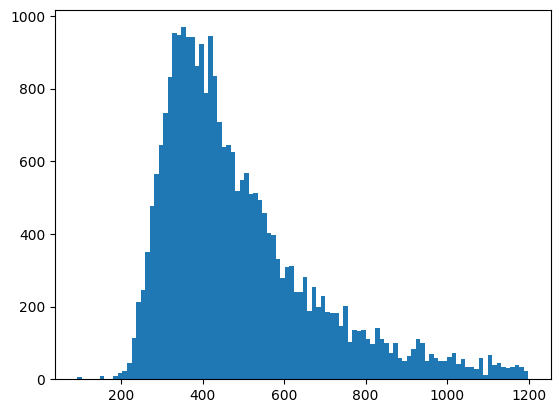

In [13]:
display(len(mlen.sort_values().unique()))
plt.hist(mlen, bins=100)
plt.show()

Number of non-zero measurements distribution

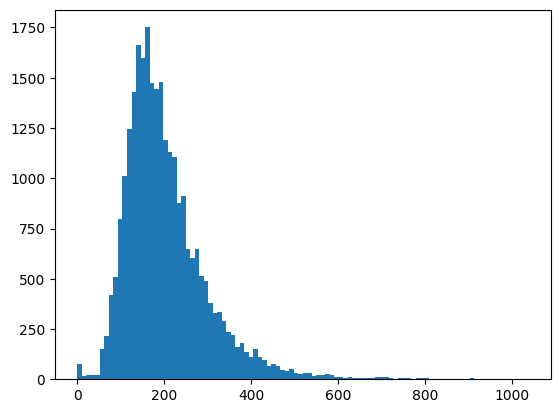

In [14]:
plt.hist(nonlen, bins=100)
plt.show()

Number of initial zero measured values distribution

In [15]:
def func(x: list):
    cnt = 0
    for el in x:
        if el != 0:
            break
        cnt += 1
    return cnt

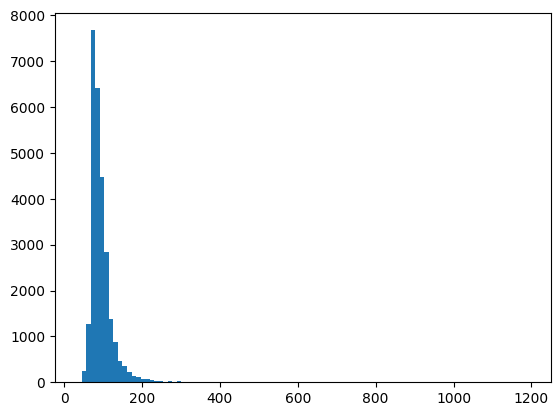

In [16]:
plt.hist(df["Pressure"].apply(func), bins=100)
plt.show()

Number of measured values differ significantly throughout cycles, therefore bucketing is not suitable method

Suitable model for dynamic systems and time series is `recurrent neural network` (RNN)

## Column selection and conversion to suitable form

Padding is needed to reach same length of training data

There is mentioned in the assignment that the most common cause of PumpFailure are events in the first half of the cycle, therefore I choose not to modify first half of the cycles

As the following output shows, there is only small fraction of the data that does not obtain zeros at the end of the cycle - therefore I choose to add zeros to the end of the series as padding

In [17]:
start = 0
end = 0
for i, x in enumerate(df["Pressure"]):
    if x[0] != 0:
        start += 1
        # print(f"start,{i}: {x[0]}")
        
    if x[-1] != 0:        
        end += 1
        # print(f"end,{i}: {x[-1]}")
print(f"Number of cycles:\nnot beginning with 0. = {start}\nnot ending    with 0. = {end}")        

Number of cycles:
not beginning with 0. = 0
not ending    with 0. = 35


Extracts cycles and its labels

In addition applies padding to the cycles

In [18]:
X = np.array(tf.keras.utils.pad_sequences(df["Pressure"], dtype='float32', padding='post')) # cycles
y = df['PumpFailed'].astype(int).values # target

Scaling

In [19]:
# # Standardizace
# scaler = StandardScaler().fit(X_Train)

# X_Train_standard = scaler.transform(X_Train)
# X_Valid_standard = scaler.transform(X_Valid)
# X_Test_standard = scaler.transform(X_Test)

# # Normalizace
# normalizer = Normalizer().fit(X_Train)

# X_Train_normalized = normalizer.transform(X_Train)
# X_Valid_normalized = normalizer.transform(X_Valid)
# X_Test_normalized = normalizer.transform(X_Test)


## Splitting into sets

In [20]:
TRAIN_SIZE = 0.7
VALID_SIZE = 0.15
TEST_SIZE = 0.15
RANDOM_SEED = 666
RANDOM_GENERATOR = torch.Generator().manual_seed(RANDOM_SEED)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=666)
print(f"Train set size: {X_train.shape[0]} ({int((1-TEST_SIZE) * 100)} %)")
print(f"Test set size: {X_test.shape[0]} ({int((TEST_SIZE) * 100)} %)")

Train set size: 22865 (85 %)
Test set size: 4035 (15 %)


Transformation of the data into appropriate format for NN

In [22]:
# Převod na tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

Check of shapes

In [23]:
display(X_train_tensor.shape)
display(y_train_tensor.shape)

torch.Size([22865, 1199])

torch.Size([22865])

Creation of dataloader for the training

In [24]:
dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

Split data to train and valid set for training

In [25]:
train_data, val_data = random_split(dataset, [TRAIN_SIZE, 1 - TRAIN_SIZE], RANDOM_GENERATOR)

## Model definition

I have not yet learned at school about recurrent networks, I know they exist, the basic principle, as far as I know, vaguely said, they are feed-forward networks with possible cycles in the layers, I hope I use them correctly :)  

As mentioned, the neural network should be recurrent. The recurrent layer is LSTM, the model is too much basic

The wage initialization should be implemented by PyTorch

In [26]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, neuron_count, hidden):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(input_size, neuron_count, batch_first=True)
        self.fc1 = nn.Linear(neuron_count, neuron_count//2)
        self.fc2 = nn.Linear(neuron_count//2, output_size)
        self.hidden = hidden

    def forward(self, x):
        x, _ = self.rnn(x) # LSTM layer
        x = self.hidden(x) # activation function after the LSTM layer
        x = self.fc1(x) # linear layer to get the output shape
        x = self.hidden(x) # activation function after the LSTM layer
        x = self.fc2(x) # linear layer to get the output shape
        x = torch.sigmoid(x) # converts output to the interval (0,1)
        return x

## Hyperparameter tuning

*Visualization function of the training process*

In [27]:
POINT_SIZE = 8
def plot_result(losses, accs, vlosses, vaccs):
    print(f"\nNejlepší výsledek na validační množině (epocha={np.argmax(vaccs)+1}):\n  Ztrátová funkce={max(vlosses):.5f}, Přesnost={max(vaccs):.2f}%")
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
    fig.suptitle("Výsledky trénování - kumulativní chyba a přesnost predikce")
    ax[0].set_xlabel("Epocha")
    ax[0].set_ylabel("Kumulativní chyba")
    ax[0].scatter(range(1, len(losses)+1), losses, c='blue', label="Trénovací", s = POINT_SIZE)
    ax[0].scatter(range(1, len(vlosses)+1), vlosses, c='red', label="Validační", s = POINT_SIZE)
    ax[0].legend()

    ax[1].set_xlabel("Epocha")
    ax[1].set_ylabel("Přesnost")
    ax[1].scatter(range(1, len(accs)+1), accs, c='blue', label="Trénovací", s = POINT_SIZE)
    ax[1].scatter(range(1, len(vaccs)+1), vaccs, c='red', label="Validační", s = POINT_SIZE)
    ax[1].plot([1, len(vaccs)+1], [max(vaccs), max(vaccs)],'g--', label="Nejvyšší přesnost na validační množině")
    ax[1].legend()
    plt.show()

*This function trains one epoch and evaluates train accuracy*

In [28]:
def train_one_epoch(model, optimizer, loss_fn, training_loader):
    running_cum_loss = 0. # kumulativní chyba
    correct = 0 # počet správně klasifikovaných

    for inputs, labels in training_loader:
        # Vynulování gradientu v každé dávce
        optimizer.zero_grad()

        # Dopředný průchod sítí
        outputs = model(inputs) # 

        # Výpočet hodnoty účelové funkce
        loss = loss_fn(outputs.squeeze(), labels) # 
        
        # Zpětné šíření chyby přes gradient
        loss.backward()

        # Aktualizace vah
        optimizer.step()

        # Sběr výsledků
        running_cum_loss += loss.item() * inputs.shape[0]
        correct += (outputs.argmax(1) == labels).sum()

    # průměrná hodnota účelové funkce na celém trénovacím datasetu
    return running_cum_loss / len(train_data), correct * 100 / len(train_data)

*This function evaluates validation accuracy*

In [29]:
def validate_model(model, loss_fn, validation_loader):
    running_cum_vloss = 0.0
    vcorrect = 0

    with torch.no_grad(): # výpočet bez gradientu
        for vinputs, vlabels in validation_loader:
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs.squeeze(), vlabels)

            # Spočítání kumulativní chyby a správně klasifikovaných
            running_cum_vloss += vloss.item() * vinputs.shape[0]
            vcorrect += (voutputs.argmax(1) == vlabels).sum()

    # Průměrná kumulativní ztráta a přesnost
    return running_cum_vloss / len(val_data), vcorrect * 100 / len(val_data)

*Helper class for regularization method early stopping*

In [30]:
class EarlyStopping:
    def __init__(self, patience=10):
        self.early_stop = False
        self.patience = patience
        self.best_loss = None
        self.not_improved = 0

    def __call__(self, vloss, model = None):
        if self.best_loss is None or self.best_loss > vloss:
            self.best_loss = vloss
            self.not_improved = 0
        else:
            self.not_improved += 1
            if self.not_improved >= self.patience:
                return True
            
        return False

*This function trains model with given hyperparameters and returns evaluation results*

In [31]:
def train(model, optimizer, loss_fn, training_loader, validation_loader, patience, epochs):
    # inicializace polí pro sběr výsledků trénování
    losses = []
    accs = []
    vlosses = []
    vaccs = []

    # zavedení early stoppingu
    early_stopping = EarlyStopping(patience)

    for _ in range(epochs):
        model.train() # indikace trénování (např. pro dropout vrstvu)
        loss, acc = train_one_epoch(model, optimizer, loss_fn, training_loader)
        model.eval() # indikace validace
        vloss, vacc = validate_model(model, loss_fn, validation_loader)

        if early_stopping(vloss, model): # předčasné ukončení
            break

        # uložení výsledků pro danou epochu
        losses.append(loss)
        accs.append(acc)
        vlosses.append(vloss)
        vaccs.append(vacc)

    return losses, accs, vlosses, vaccs

*This function initialize model with given hyperparameters*

In [32]:
def init_model(neuron_count, hidden, opt_method, learning_rate, L2_reg, batch_size):
    # inicializace modelu
    model = RNN(len(X_train[0]), 1, neuron_count, hidden)

    # inicializace optimalizační metody
    optimizer = opt_method(model.parameters(), lr=learning_rate, weight_decay=L2_reg) # weight_decay ovlivňuje regularizaci L2 normy vah

    # inicializace dávkovačů trénovacích a validačních dat
    training_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) # parametr shuffle zamíchá dávku
    validation_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    return model, optimizer, training_loader, validation_loader

The criterion function suitable for this task is Binary cross-entropy 

In [33]:
LOSS_FN = nn.BCELoss()

Hyperparameters, only some of them are used due to deadline coming:/

The results really doesn't look good, the model predicts only 0. It may be due to:
- disproportion of True/False values in the target variable
- simplicity of the NN
- some mistake :(

The possible solutions that I don't have space for are:
- more regularization techniques that prevent overfitting
- modify proportion of False/True labels

In [34]:
NEURON_COUNTS = [128, 256] # počet neuronů ve vrstvě
BATCH_SIZES = [64, 128] # velikost dávky při trénování
HIDDENS = [nn.Sigmoid(), nn.LeakyReLU()] # aktivační funkce skrytých vrstev
OPTIMIZERS = [optim.Adam, optim.SGD] # optimalizační metody gradientního sestupu
L2_REGS = [0.001] # L2 regularizace (0 znamená žádná)
EARLY_STOPPING_PATIENCE = [5] # velikost tolerované sekvence zhoršování modelu
EPOCHS = 100 # maximální počet epoch
LEARNING_RATE = 0.001 # statický parametr optimalizační metody SGD
DROPOUT_PROBS = [0, 0.3] # not used yet

Optimization method: <class 'torch.optim.adam.Adam'>
Activation function: Sigmoid()
L2 regularization member: 0.001
Early stopping patience: 5
Neuron count in the sequential layer: 128
Batch size: 64

Nejlepší výsledek na validační množině (epocha=1):
  Ztrátová funkce=0.34728, Přesnost=89.07%


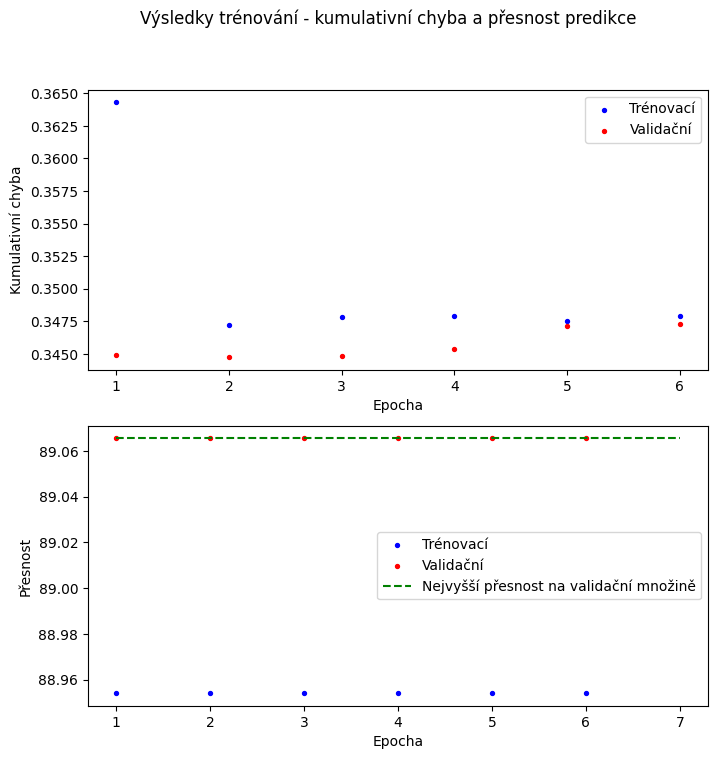

Optimization method: <class 'torch.optim.sgd.SGD'>
Activation function: Sigmoid()
L2 regularization member: 0.001
Early stopping patience: 5
Neuron count in the sequential layer: 128
Batch size: 64

Nejlepší výsledek na validační množině (epocha=1):
  Ztrátová funkce=0.42160, Přesnost=89.07%


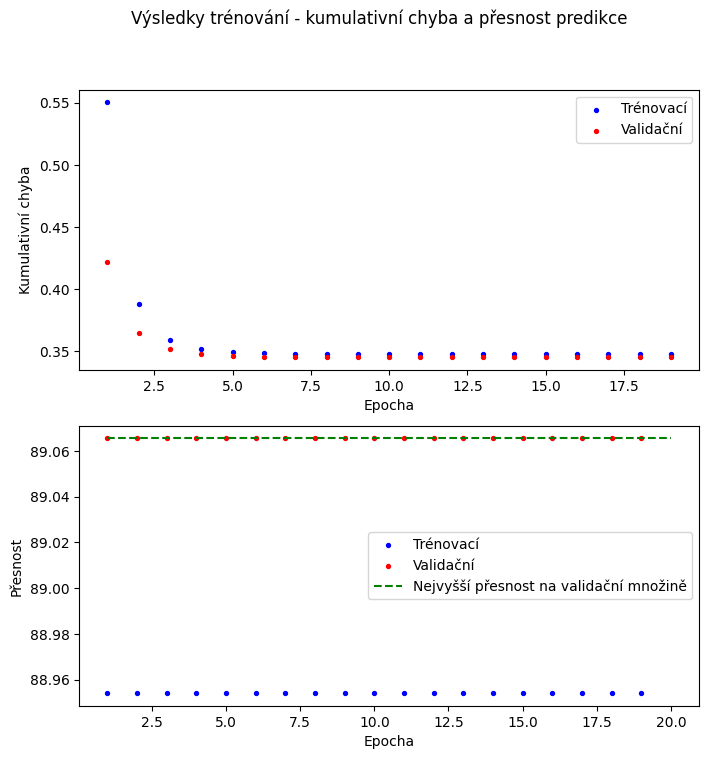

Optimization method: <class 'torch.optim.adam.Adam'>
Activation function: LeakyReLU(negative_slope=0.01)
L2 regularization member: 0.001
Early stopping patience: 5
Neuron count in the sequential layer: 128
Batch size: 64

Nejlepší výsledek na validační množině (epocha=1):
  Ztrátová funkce=0.34431, Přesnost=89.07%


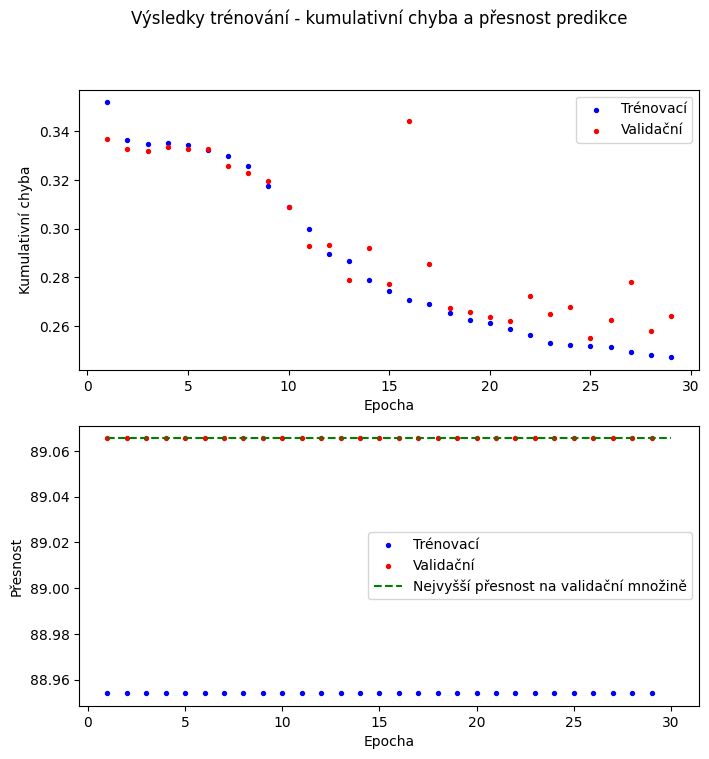

Optimization method: <class 'torch.optim.sgd.SGD'>
Activation function: LeakyReLU(negative_slope=0.01)
L2 regularization member: 0.001
Early stopping patience: 5
Neuron count in the sequential layer: 128
Batch size: 64

Nejlepší výsledek na validační množině (epocha=1):
  Ztrátová funkce=0.56627, Přesnost=89.07%


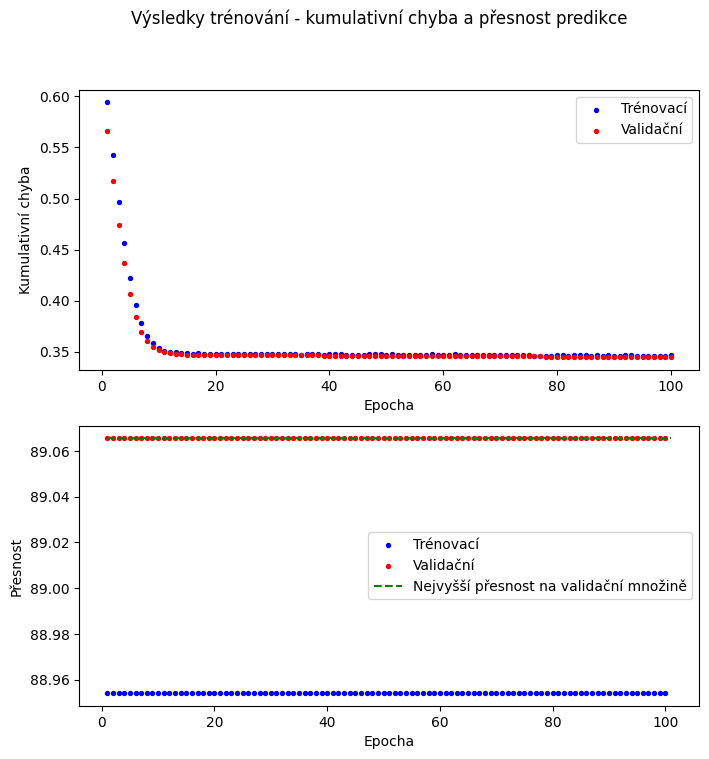

Optimization method: <class 'torch.optim.adam.Adam'>
Activation function: Sigmoid()
L2 regularization member: 0.001
Early stopping patience: 5
Neuron count in the sequential layer: 256
Batch size: 64

Nejlepší výsledek na validační množině (epocha=1):
  Ztrátová funkce=0.34962, Přesnost=89.07%


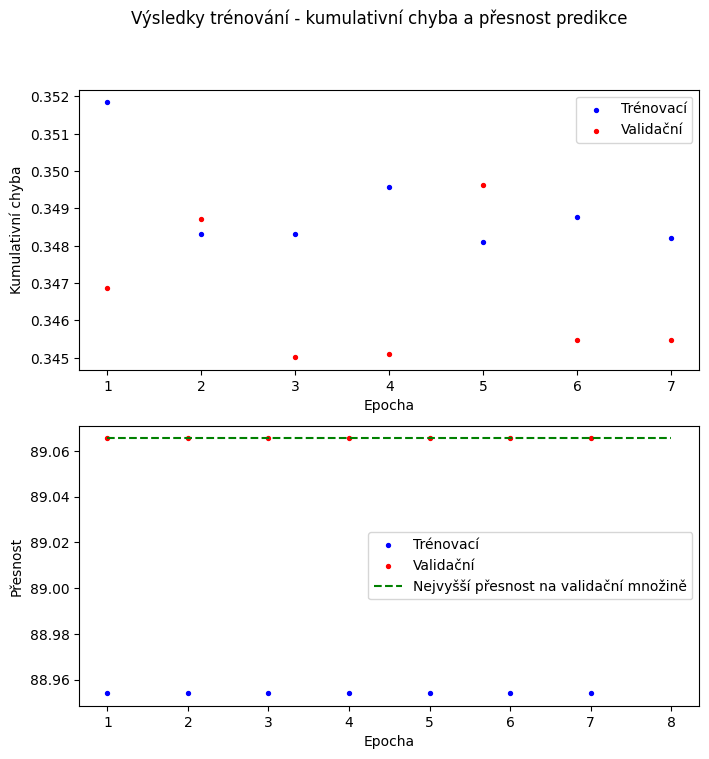

Optimization method: <class 'torch.optim.sgd.SGD'>
Activation function: Sigmoid()
L2 regularization member: 0.001
Early stopping patience: 5
Neuron count in the sequential layer: 256
Batch size: 64

Nejlepší výsledek na validační množině (epocha=1):
  Ztrátová funkce=0.36687, Přesnost=89.07%


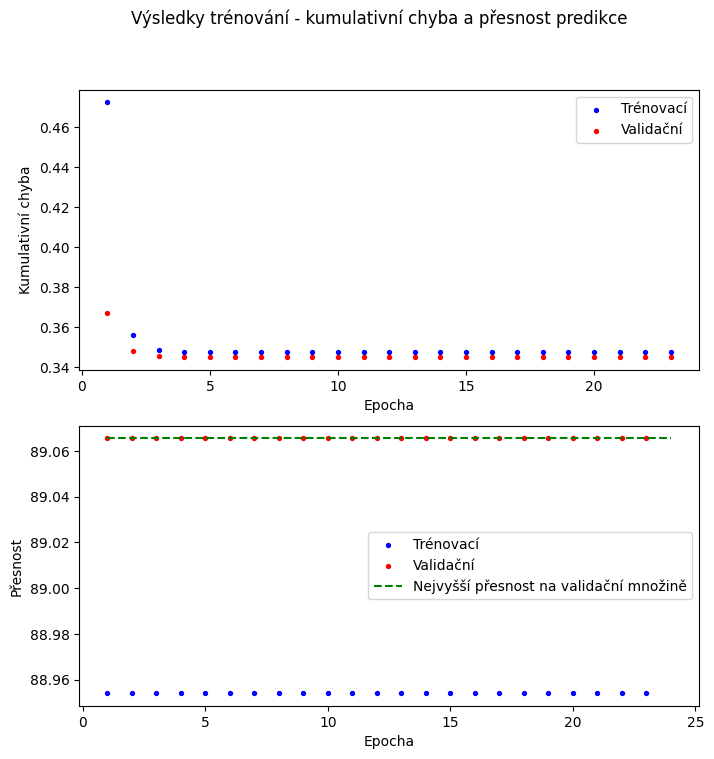

Optimization method: <class 'torch.optim.adam.Adam'>
Activation function: LeakyReLU(negative_slope=0.01)
L2 regularization member: 0.001
Early stopping patience: 5
Neuron count in the sequential layer: 256
Batch size: 64

Nejlepší výsledek na validační množině (epocha=1):
  Ztrátová funkce=0.33895, Přesnost=89.07%


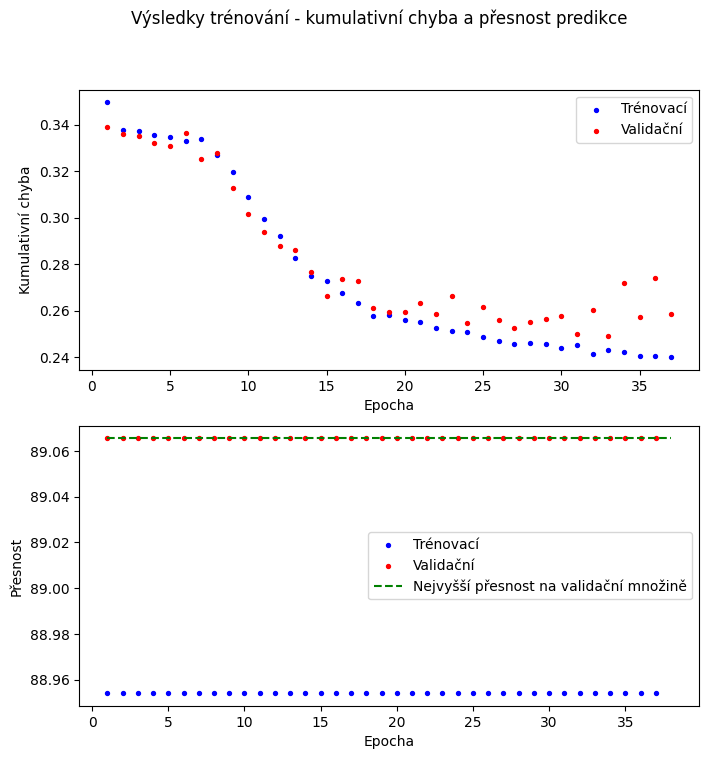

Optimization method: <class 'torch.optim.sgd.SGD'>
Activation function: LeakyReLU(negative_slope=0.01)
L2 regularization member: 0.001
Early stopping patience: 5
Neuron count in the sequential layer: 256
Batch size: 64

Nejlepší výsledek na validační množině (epocha=1):
  Ztrátová funkce=0.59737, Přesnost=89.07%


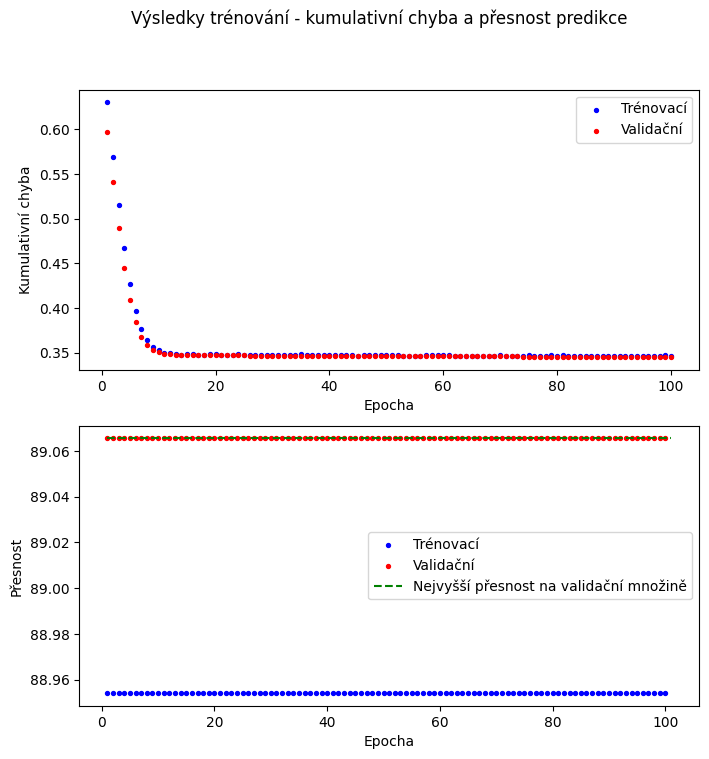

Optimization method: <class 'torch.optim.adam.Adam'>
Activation function: Sigmoid()
L2 regularization member: 0.001
Early stopping patience: 5
Neuron count in the sequential layer: 128
Batch size: 128

Nejlepší výsledek na validační množině (epocha=1):
  Ztrátová funkce=0.34693, Přesnost=89.07%


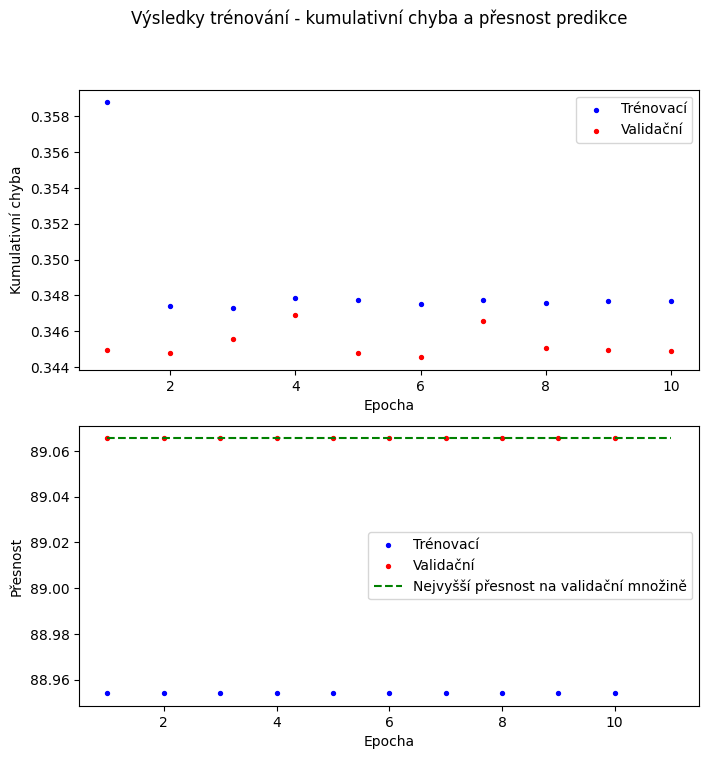

Optimization method: <class 'torch.optim.sgd.SGD'>
Activation function: Sigmoid()
L2 regularization member: 0.001
Early stopping patience: 5
Neuron count in the sequential layer: 128
Batch size: 128

Nejlepší výsledek na validační množině (epocha=1):
  Ztrátová funkce=0.54891, Přesnost=89.07%


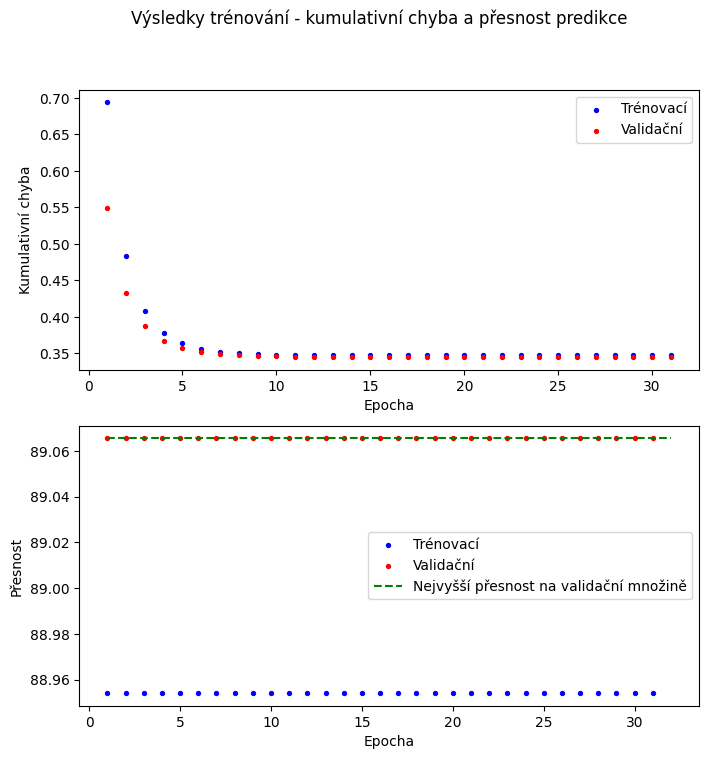

Optimization method: <class 'torch.optim.adam.Adam'>
Activation function: LeakyReLU(negative_slope=0.01)
L2 regularization member: 0.001
Early stopping patience: 5
Neuron count in the sequential layer: 128
Batch size: 128

Nejlepší výsledek na validační množině (epocha=1):
  Ztrátová funkce=0.34396, Přesnost=89.07%


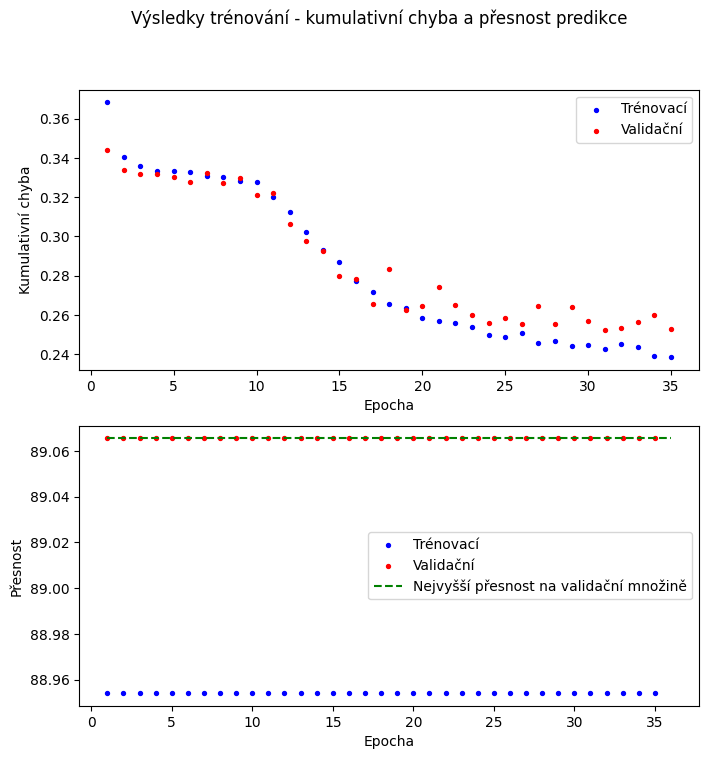

Optimization method: <class 'torch.optim.sgd.SGD'>
Activation function: LeakyReLU(negative_slope=0.01)
L2 regularization member: 0.001
Early stopping patience: 5
Neuron count in the sequential layer: 128
Batch size: 128

Nejlepší výsledek na validační množině (epocha=1):
  Ztrátová funkce=0.66761, Přesnost=89.07%


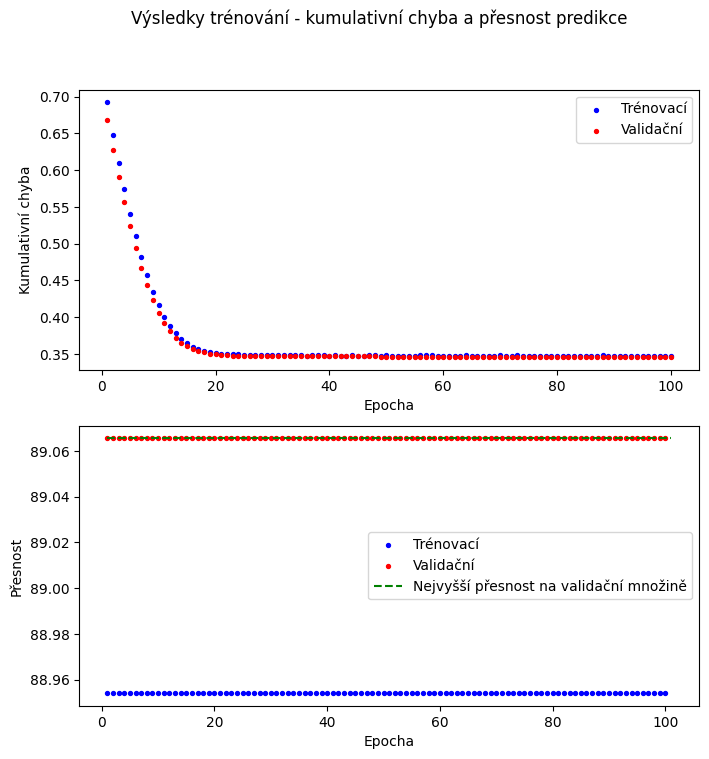

Optimization method: <class 'torch.optim.adam.Adam'>
Activation function: Sigmoid()
L2 regularization member: 0.001
Early stopping patience: 5
Neuron count in the sequential layer: 256
Batch size: 128

Nejlepší výsledek na validační množině (epocha=1):
  Ztrátová funkce=0.35006, Přesnost=89.07%


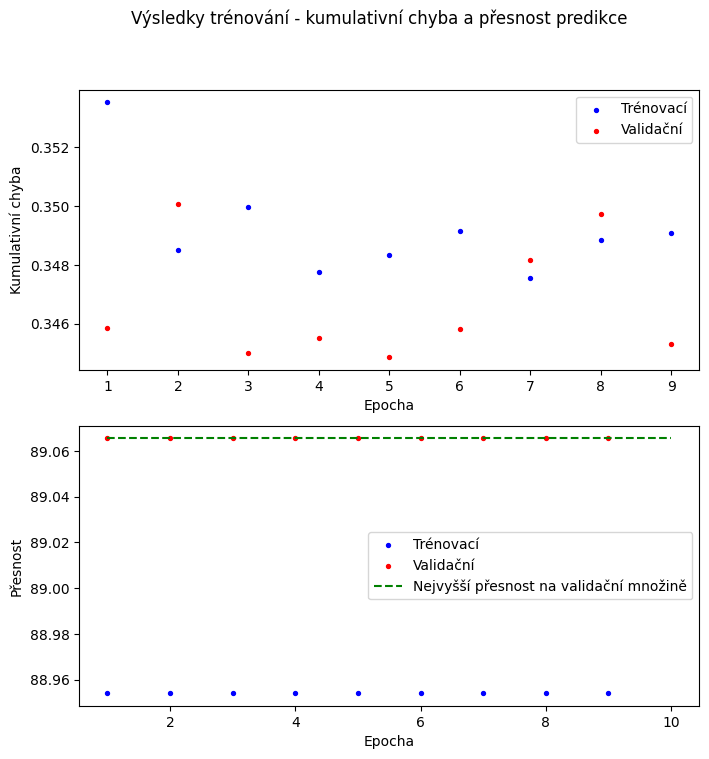

Optimization method: <class 'torch.optim.sgd.SGD'>
Activation function: Sigmoid()
L2 regularization member: 0.001
Early stopping patience: 5
Neuron count in the sequential layer: 256
Batch size: 128

Nejlepší výsledek na validační množině (epocha=1):
  Ztrátová funkce=0.40570, Přesnost=89.07%


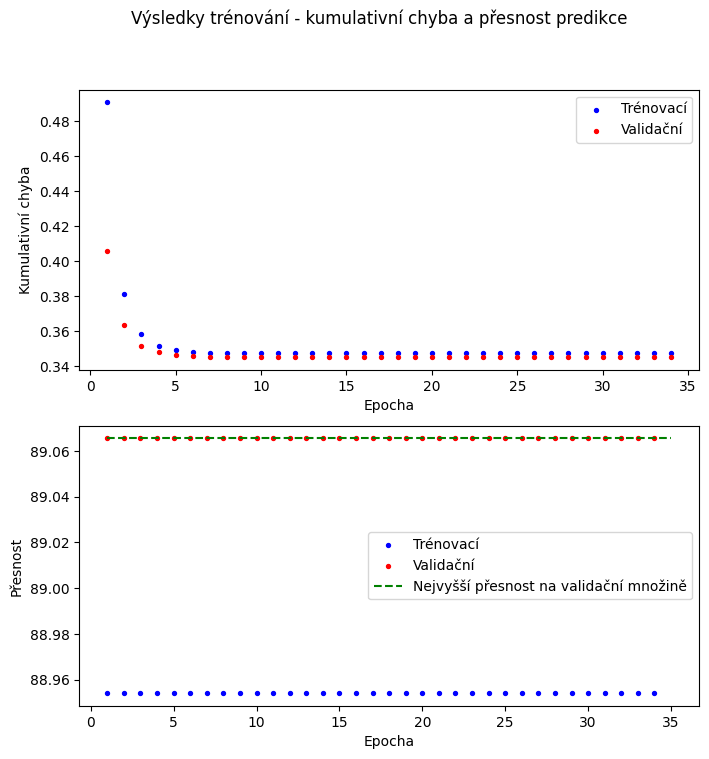

Optimization method: <class 'torch.optim.adam.Adam'>
Activation function: LeakyReLU(negative_slope=0.01)
L2 regularization member: 0.001
Early stopping patience: 5
Neuron count in the sequential layer: 256
Batch size: 128

Nejlepší výsledek na validační množině (epocha=1):
  Ztrátová funkce=0.34400, Přesnost=89.07%


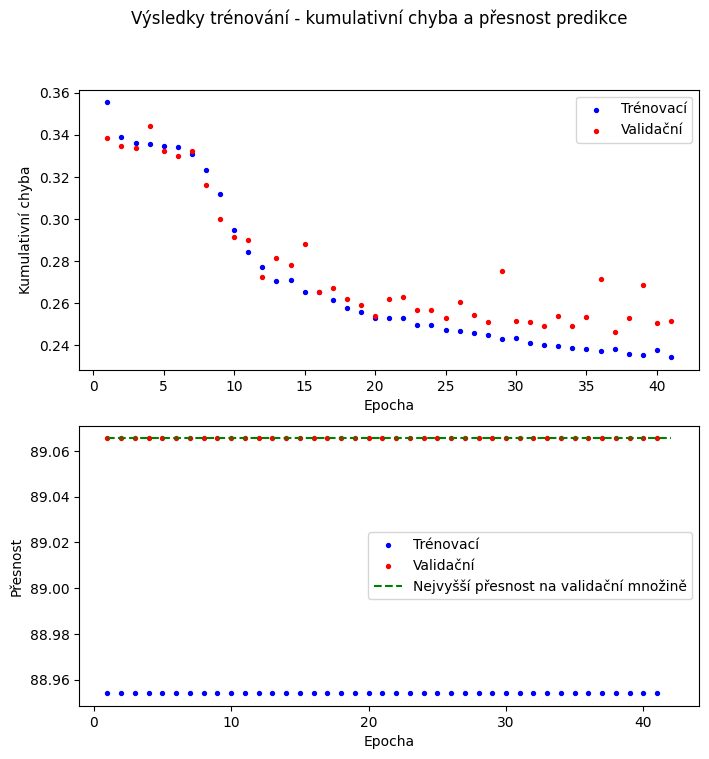

Optimization method: <class 'torch.optim.sgd.SGD'>
Activation function: LeakyReLU(negative_slope=0.01)
L2 regularization member: 0.001
Early stopping patience: 5
Neuron count in the sequential layer: 256
Batch size: 128

Nejlepší výsledek na validační množině (epocha=1):
  Ztrátová funkce=0.68042, Přesnost=89.07%


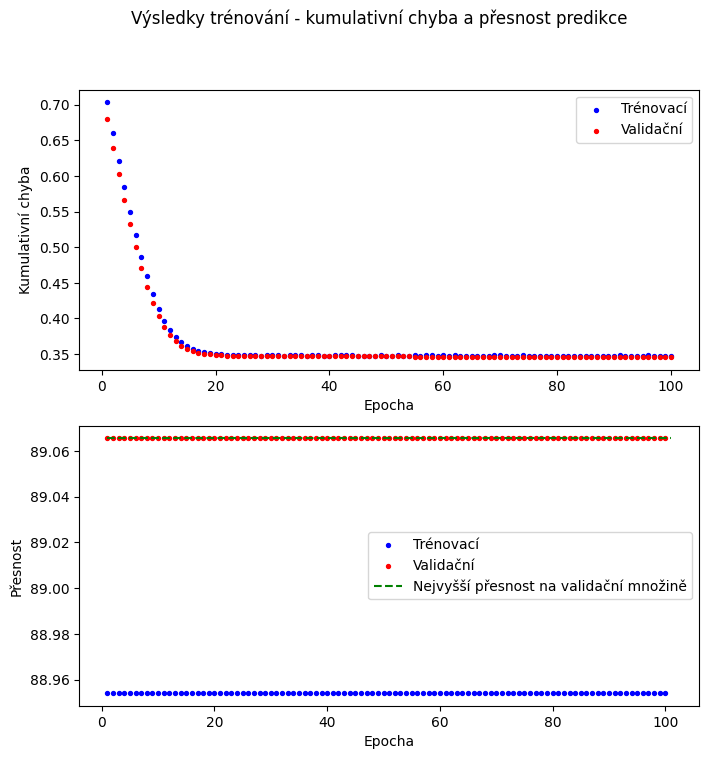

In [35]:
best_acc = None
final_model = None
for batch_size in BATCH_SIZES:
    for neuron_count in NEURON_COUNTS:
        for patience in EARLY_STOPPING_PATIENCE:
            for L2_reg in L2_REGS:
                for hidden in HIDDENS:
                    for opt_method in OPTIMIZERS:
                        # preparation
                        model, optimizer, training_loader, validation_loader = init_model(neuron_count, hidden, opt_method, LEARNING_RATE, L2_reg, batch_size)

                        # training
                        losses, accs, vlosses, vaccs = train(model, optimizer, LOSS_FN, training_loader, validation_loader, patience, EPOCHS)

                        # best model retrieval
                        if not best_acc or np.max(vaccs) > best_acc:
                            best_acc = np.max(vaccs)
                            final_model = model
                        
                        print(f"Optimization method: {opt_method}")
                        print(f"Activation function: {hidden}")
                        print(f"L2 regularization member: {L2_reg}")
                        print(f"Early stopping patience: {patience}")
                        print(f"Neuron count in the sequential layer: {neuron_count}")
                        print(f"Batch size: {batch_size}")

                        plot_result(losses, accs, vlosses, vaccs)

In [36]:
print(f"Best accuracy on validation set: {best_acc:.1f}%")

Best accuracy on validation set: 89.1%


## Accuracy estimate

In this case, where the predictions don't work well the result has no big meaning, but the following code tests the accuracy on the test set.

Accuracy on test set: 89.492%
Confusion matrix:


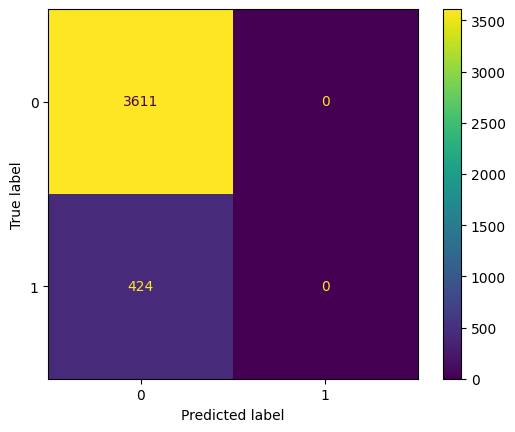

In [37]:
with torch.no_grad():
    outputs = final_model(X_test_tensor)
    predictions = outputs.argmax(1).numpy()
    
# Přesnost
print(f"Accuracy on test set: {100 * accuracy_score(y_test, predictions):.3f}%")

# Matice záměn
print("Confusion matrix:")
ConfusionMatrixDisplay.from_predictions(y_test, predictions)

# uložení modelu
torch.save(final_model.state_dict(), "final_model.pt")